# Projeto IA 1ªParte

#### THE_3_MUSKETEERS

###### Edith Cardoso - a22007545; Frederico Azevedo - a21900295; Nuno Rasteiro - a21906959;


### Importar libs


In [1]:
import csv as csv
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import math


### Algoritmo de pesquisa informada num ambiente estático com obstáculos. 

### O objetivo será encontrar o caminho de menor custo desde o nó de partida até ao nó final.


Começamos por criar variaveis globais que vão conter os pesos de cada tipo de etiqueta no mapa.

Estes pesos são-nos dados na seguinte tabela.

<img src= "res/tabelaetiquetas.PNG">


Criámos também variáveis globais com o nome dos ficheiros que utilizamos

In [2]:
CUSTO_T = 1
CUSTO_A = 3
CUSTO_F_B = 500  # Quando ve F ou B nao considera que é filho do nó

mapa_100x100 = 'sample-environment.csv' # Mudar esta string quando se quiser alterar o ficheiro de 100x100
mapa_15x15 = '15x15.csv'
save = 'final.csv'

Depois criámos uma função para ler o mapa de um csv para um dataframe usando o pandas.


In [3]:
# Importar dados do CSV para
def ler_csv(path):
    df = pd.read_csv(path)
    
    # apagar primeira coluna
    df = df.iloc[:, 1:]
    return df

Agora temos o objetivo de converter este mapa, que temos num dataframe, para um dataset que contenha as ligações possiveis a partir de um nó chave, bem como o seu custo.

Para isso criámos funções que nos ajudam nos passos intermédios dessa conversão.


In [4]:
#Função para obter as cordenadas das etiquetas 'S' e 'E'
def retornar_cordenadas_inicio_fim(mapa):
    """
    Retorna as cordenadas de inicio do jogo e do fim do jogo.

    INPUT:
    dataframe   mapa
    """
    for linha in mapa:
        for coluna in mapa:
            temp_linha = int(linha)
            temp_coluna = int(coluna)
            etiqueta = mapa.loc[temp_linha][temp_coluna]
            
            if (etiqueta in ['S', 'E']):
                if(etiqueta == 'S'):
                    cordenadas_inicio = f'{linha},{coluna}'

                if(etiqueta == 'E'):
                    cordenadas_fim = f'{linha},{coluna}'

    return cordenadas_inicio, cordenadas_fim


In [5]:
#Funções para calcular os custos 
def c(n):
    """
    Dada uma etiqueta 'n' retorna o seu custo
    
    INPUT:
    string   n
    """
    C = {
        'T': CUSTO_T,
        'A': CUSTO_A,
        'S': 0,
        'E': 0,
        'F': CUSTO_F_B,
        'B': CUSTO_F_B,
    }

    return C[n]

In [6]:
# Funcao para calcular as oito direçoes possiveis de andar
def obtem_direcoes_possiveis(linha, coluna):
    """
    A partir de um par linha, coluna (posição atual) retorna uma lista com as oito posições possiveis de se movimentar

    INPUT:
    int         linha
    int         coluna
    """
    direcoes = [f'{max(linha-1,0)},{max(coluna-1,0)}',  # ↖
                f'{max(linha-1,0)},{coluna}',           # ↑
                f'{max(linha-1,0)},{min(coluna+1,99)}', # ↗
                f'{linha},{min(coluna+1,99)}',          # →
                f'{min(linha+1,99)},{min(coluna+1,99)}',# ↘
                f'{min(linha+1,99)},{coluna}',          # ↓
                f'{max(linha-1,0)},{max(coluna-1,0)}',  # ↙
                f'{min(linha+1,99)},{max(coluna-1,0)}', # ←
                f'{linha},{max(coluna-1,0)}']           # ↖

    return direcoes


Depois de termos todas as funções intermediárias podemos então converter o mapa num dataset que servirá de lista de adjacencia.

Para isso fizemos a função abaixo.

In [7]:
# Funcao para criar dataset com os custos
def cria_dataset(mapa):
    """
    Cria um dataset em que a chave é uma posicao do mapa, e os valores são um dicionário do tipo { posição_filho : custo }

    INPUT:
    dataframe   mapa
    """
    df = dict()
    custo_total = 0
    for linha in range(0, len(mapa) - 1):
            for coluna in range(0, len(mapa.columns) - 1):
                    key = f'{linha},{coluna}'
                    etiqueta = mapa.loc[int(linha)][int(coluna)]
                    if etiqueta not in ['B', 'F']:
                        direcoes = obtem_direcoes_possiveis(int(linha), int(coluna))
                        for i in range(len(direcoes)):
                            temp_linha, temp_coluna = direcoes[i].split(',')
                            etiqueta = mapa.loc[int(temp_linha)][int(temp_coluna)] #recebe a etiqueta que está na posição do mapa
                            if etiqueta not in ['B', 'F']:
                                current_key = str(temp_linha) + \
                                    ',' + str(temp_coluna)
                                custo = c(etiqueta)
                                
                                if key not in df:
                                    custo_total += custo
                                    df[key] = ({current_key: custo})
                                else:
                                    df[key].update({current_key: custo})
                                
    return df


Optamos por usar o algoritmo A* para solucionar este problema.

Para a heuristica optamos por usar a distância diagonal, uma vez que é a mais eficiente e eficaz quando se pode andar em 8 direções.

In [8]:
def h(c1, c2, cf1, cf2, custo_movimento = 1.333):
    """
    Calcula a heuristica de uma dada posição (c1,c2) até à posição final (cf1, cf2), usando a distância diagonal.
    É usado o custo movimento para optimizar a performance e por ser a média entre o custo da terra e custo da àgua.
    INPUT:
    int         c1
    int         c2
    int         cf1
    int         cf2
    int         custo_movimento
    """
    dx = abs(c1 - cf1)
    dy = abs(c2 - cf2)
    return custo_movimento * (dx + dy) + (math.sqrt(custo_movimento) - 2 * custo_movimento) * min(dx, dy)

In [9]:
def a_star(lista_adj, start_node, stop_node):
    # open_list -> lista de nós que foram visitados,  mas que os seus vizinhos nao foram todos inspecionados
    # closed_list -> lista de nós que foram visitados e que todos os seus vizinhos foram inspecionados
    # visitados -> guarda os nós visitados
    open_list = set([start_node])
    closed_list = set([])
    visitados = set([])
    
    cf1, cf2 = stop_node.split(',') # cordenadas do nó de destino

    # g contem a distancia atual do nó de inicio até ao nó em questão
    g = {}
    g[start_node] = 0

    # parents contem um mapa de adjacencia de todos os nós 
    # é usado para, no final da funcao, recriar o caminho 
    parents = {}
    parents[start_node] = start_node

    while len(open_list) > 0:
        n = None

        # encontra um nó com o menos valor de f() -> g + h
        for v in open_list:
            x_v, y_v = v.split(",")
            if n is not None:
                x_n, y_n = n.split(",")
            if n == None or g[v] + h(int(x_v), int(y_v), int(cf1), int(cf2)) < g[n] + h(int(x_n), int(y_n), int(cf1), int(cf2)):
                n = v
                visitados.add(n)
            
        if n == None:
            print('Não existe caminho!')
            return None

        # se encontrar o nó de destino 
        # reconstroi o caminho a partir do nó de início e retorna
        if n == stop_node:
            reconst_path = []

            while parents[n] != n:
                reconst_path.append(n)
                n = parents[n]

            reconst_path.append(start_node)
            reconst_path.reverse()

            return reconst_path, visitados

        # para todos os vizinhos do nó atual faz
        for m in lista_adj[f"{n}"]:
            weight = lista_adj[f"{n}"].get(f"{m}")
            # se o nó atual nao estiver na open_list nem na closed_list 
            # adicionamo-lo à open_list e indicamos n como sendo o seu pai
            if m not in open_list and m not in closed_list:
                open_list.add(m)
                parents[m] = n
                g[m] = g[n] + weight

            # senão, verofica se é mais rápido visitar primeiro n e depois m
            # e se for, atualiza nas variáveis parent e g
            # e se o nó estiver na closed_list, move-o para a open_list
            else:
                if g[m] > g[n] + weight:
                    g[m] = g[n] + weight
                    parents[m] = n

                    if m in closed_list:
                        closed_list.remove(m)
                        open_list.add(m)

        # remove n da open_list e move-o para a closed_list
        # porque todos os seus vizinhos foram inspecionados
        open_list.remove(n)
        closed_list.add(n)

    print('Não existe caminho!')
    return None


Depois de obtermos o caminho resultante do A* usamos as seguintes funções para calcular e mostrar os resultados

In [10]:
#Função para calcular o custo do caminho resultante do A*
def calcula_custo_caminho(caminho, mapa):
    """
    Calcula o custo total de um caminho.

    INPUT:
    list        caminho
    dataframe   mapa
    """
    # custo = 0
    # for node in caminho:
    #     cord1, cord2 = node.split(',')
    #     custo += c(mapa.loc[int(cord1)][int(cord2)])
    #     print(custo)
    # return custo
    return sum([(c(mapa.loc[int(node.split(',')[0])][int(node.split(',')[1])])) for node in caminho])

In [11]:
#Função para construir um mapa para ser impresso como heatmap, por questoes de visualização :)
def constroi_mapa_final(mapa, visitados, caminho):
    """
    Constroi o dataframe do mapa final, substitui os nós visitados pela etiqueta 'V' e os nós do menor caminho pela etiqueta 'SP'.

    INPUT:
    dataframe   mapa
    list        visitados
    list        caminho
    """
    mapa_final = mapa.copy(deep=True)
    
    if visitados != None:
        for node in visitados:
            cord1, cord2 = node.split(",")
            mapa_final.loc[int(cord1)][int(cord2)] = 'V'

    for node in caminho:
        cord1, cord2 = node.split(",")
        mapa_final.loc[int(cord1)][int(cord2)] = 'SP'

    return mapa_final

In [12]:
#Função para exportar o mapa resultado para csv
def exporta_df_csv(df, path = save):
    """
    Exporta um dataframe para csv.
    
    INPUT:
    dataframe   df
    """
    df.to_csv(path, encoding='utf-8', index=False)

In [13]:
#Função para gerar o heatmap do mapa
def df_para_heatmap(mapa):
    """
    Converte um dataframe para um heatmap, e imprime-o no ecrã.
    
    INPUT:
    dataframe   mapa
    """
    altera = {
        'SP': 10,
        'V': 6,
        'A': -10,
        'T': 2,
        'S': 0,
        'E': 0,
        'F': 15,
        'B': 15,
        }
    
    aux_mapa = mapa.copy(deep=True)
    aux_mapa = aux_mapa.replace(altera)
    
    sns.heatmap(aux_mapa, square=True, center=0, yticklabels=False, xticklabels=False)
    plt.show()

    

#### Função Principal

In [14]:
class Game():
    def __init__(self):
        self.run_game()

    def run_game(self):
        #Lê o mapa do CSV
        mapa = ler_csv(mapa_100x100)
        print(" == Mapa Inicial ==")
        df_para_heatmap(mapa)
        #Cria uma lista de adjacencia a partir do mapa
        dataset = cria_dataset(mapa)
        #Procura no mapa as coordenadas das etiquetas 'S' e 'E'
        coordenadas = retornar_cordenadas_inicio_fim(mapa)
        #Utiliza o algoritmo A* e guarda o caminho obtido e uma lista com os nós visitados
        caminho, visitados = a_star(dataset,coordenadas[0],coordenadas[1])
        #Calcula o custo a partir do caminho obtido no A*
        custo = calcula_custo_caminho(caminho, mapa)
        #Constroi o mapa final para ser exportado para o CSV
        mapa_final = constroi_mapa_final(mapa, visitados, caminho)
        print(f"Caminho encontrado!\n{caminho}\n\n== Estatísticas ==\nCusto = \033[1;32m{custo}\u001b[0m\nCaminho passa por \033[1;32m{len(caminho)}\u001b[0m nós.\nForam visitados \033[1;32m{len(visitados)}\u001b[0m nós.\n")
        print("== Mapa Final ==\n\033[1;32mLaranja -> Percorrido\nVermelho -> Visitado")
        exporta_df_csv(mapa_final)
        df_para_heatmap(mapa_final)
        df_para_heatmap(constroi_mapa_final(mapa, None, caminho))

 == Mapa Inicial ==


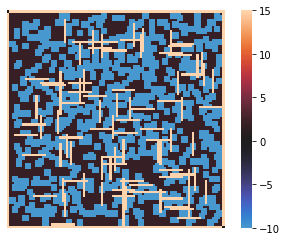

Caminho encontrado!
['0,0', '1,1', '2,2', '3,3', '4,4', '5,5', '6,6', '7,6', '8,6', '9,6', '10,6', '11,6', '12,7', '13,8', '14,9', '15,10', '16,11', '17,12', '18,12', '19,12', '20,12', '21,13', '21,14', '21,15', '20,16', '19,17', '18,18', '19,19', '20,20', '21,21', '21,22', '20,23', '19,24', '19,25', '19,26', '20,27', '21,28', '22,29', '23,30', '24,31', '24,32', '25,33', '26,34', '26,35', '27,36', '28,36', '29,36', '30,36', '31,37', '32,38', '33,39', '34,40', '34,41', '35,42', '36,43', '35,44', '34,45', '33,46', '33,47', '33,48', '32,49', '32,50', '32,51', '33,52', '34,53', '35,54', '35,55', '35,56', '35,57', '35,58', '36,59', '37,60', '37,61', '38,62', '39,63', '40,64', '41,65', '42,66', '43,67', '44,67', '45,68', '46,69', '47,70', '48,71', '49,72', '50,73', '51,74', '51,75', '51,76', '52,77', '53,77', '54,77', '55,76', '56,77', '57,78', '58,78', '59,78', '60,77', '61,78', '62,79', '63,79', '64,79', '65,79', '66,80', '67,81', '68,82', '69,82', '70,83', '71,84', '71,85', '71,86', '71,8

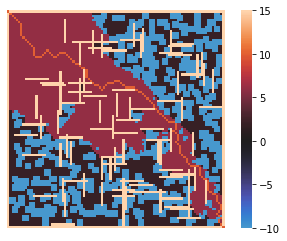

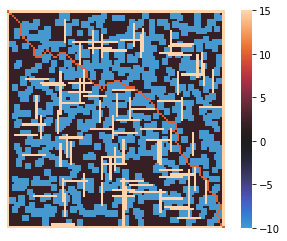

CPU times: total: 6.27 s
Wall time: 6.38 s


In [15]:
%%time
def main():
    g = Game()
    


if __name__ == "__main__":
    main()
